In [5]:
from dotenv import load_dotenv
import os
from google.cloud import bigquery
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="whitegrid")

In [6]:
load_dotenv()
key = os.getenv("linkfile")
client = bigquery.Client.from_service_account_json(key)

In [11]:
query = """
SELECT 
    COUNT(DISTINCT carrier) AS num_carriers,
    COUNT(DISTINCT origin) AS num_origins,
    COUNT(DISTINCT destination) AS num_destinations,
    COUNT(DISTINCT flight_number) AS flight_numbers,
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`

"""
df_1= client.query(query).to_dataframe()
df_1


,num_carriers,num_origins,num_destinations,flight_numbers
0,616,3617,3618,9996


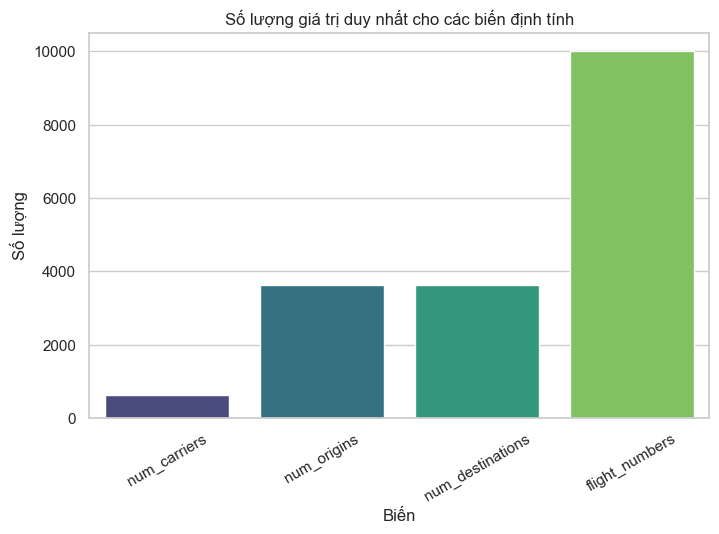

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển dữ liệu df_ từ một dòng thành dạng "tên biến - giá trị"
data = df_1.melt(var_name='Variable', value_name='Count')

plt.figure(figsize=(8,5))
sns.barplot(x='Variable', y='Count', data=data, palette='viridis')

plt.title("Số lượng giá trị duy nhất cho các biến định tính")
plt.ylabel("Số lượng")
plt.xlabel("Biến")
plt.xticks(rotation=30)
plt.show()


In [13]:
query = """
SELECT CONCAT(origin, ' → ', destination) AS route, COUNT(*) AS num_flights
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
GROUP BY route
ORDER BY num_flights DESC
LIMIT 10

"""
df_2 = client.query(query).to_dataframe()
df_2


,route,num_flights
0,GMP → CJU,32360
1,CJU → GMP,32259
2,MEL → SYD,27866
3,SYD → MEL,27858
4,HND → CTS,23335
5,CTS → HND,23335
6,HND → FUK,20892
7,FUK → HND,20889
8,HAN → SGN,19923
9,CGH → SDU,19476


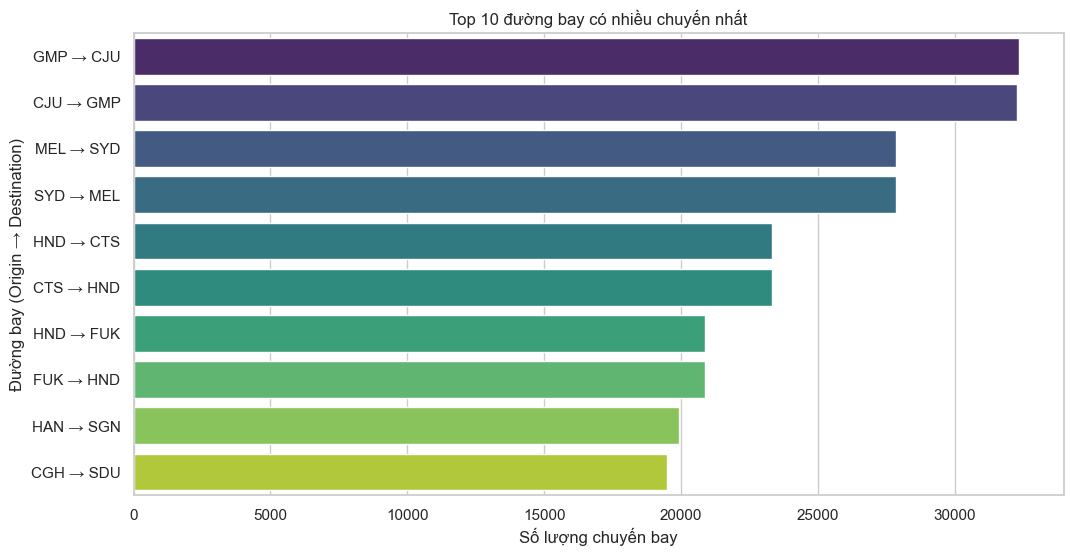

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x='num_flights', y='route', data=df_2, palette='viridis')

plt.title("Top 10 đường bay có nhiều chuyến nhất")
plt.xlabel("Số lượng chuyến bay")
plt.ylabel("Đường bay (Origin → Destination)")
plt.show()


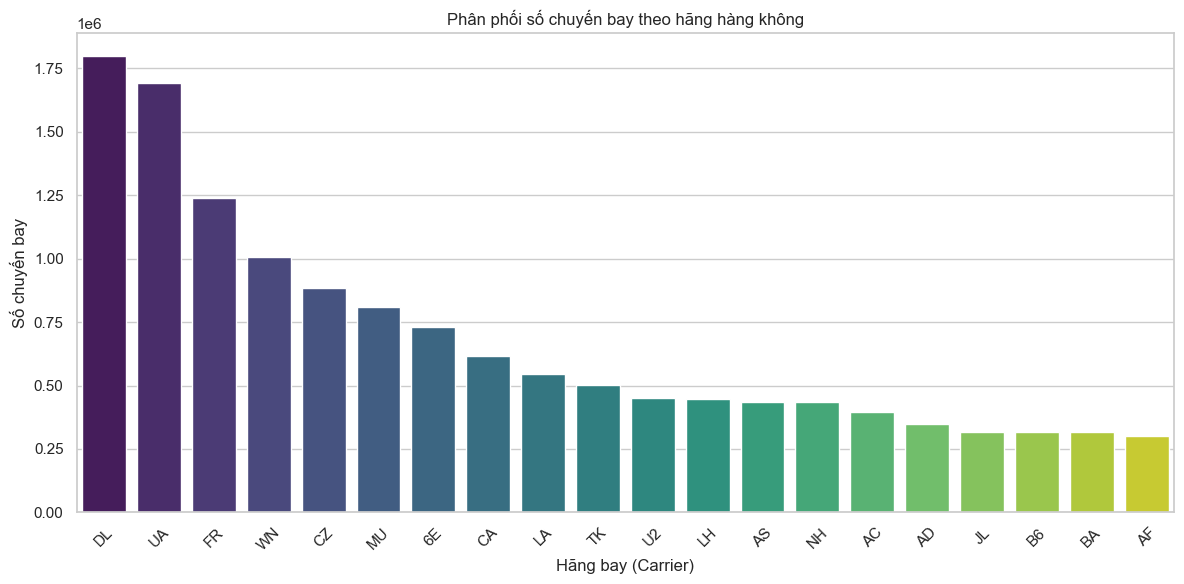

In [3]:
query = """
SELECT 
  carrier,
  COUNT(*) AS flight_count
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
GROUP BY carrier
ORDER BY flight_count DESC
LIMIT 20
"""
df_carrier = client.query(query).to_dataframe()

plt.figure(figsize=(12,6))
sns.barplot(data=df_carrier, x='carrier', y='flight_count', palette='viridis')
plt.title("Phân phối số chuyến bay theo hãng hàng không")
plt.xlabel("Hãng bay (Carrier)")
plt.ylabel("Số chuyến bay")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

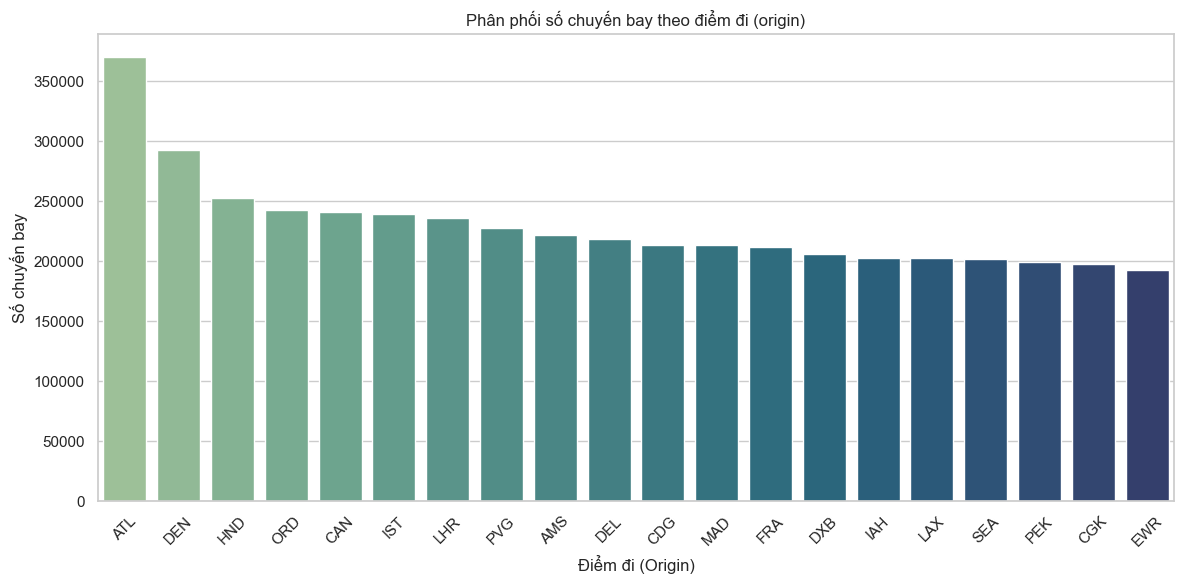

In [4]:
query_origin = """
SELECT 
  origin,
  COUNT(*) AS flight_count
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
GROUP BY origin
ORDER BY flight_count DESC
LIMIT 20
"""
df_origin = client.query(query_origin).to_dataframe()

plt.figure(figsize=(12,6))
sns.barplot(data=df_origin, x='origin', y='flight_count', palette='crest')
plt.title("Phân phối số chuyến bay theo điểm đi (origin)")
plt.xlabel("Điểm đi (Origin)")
plt.ylabel("Số chuyến bay")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


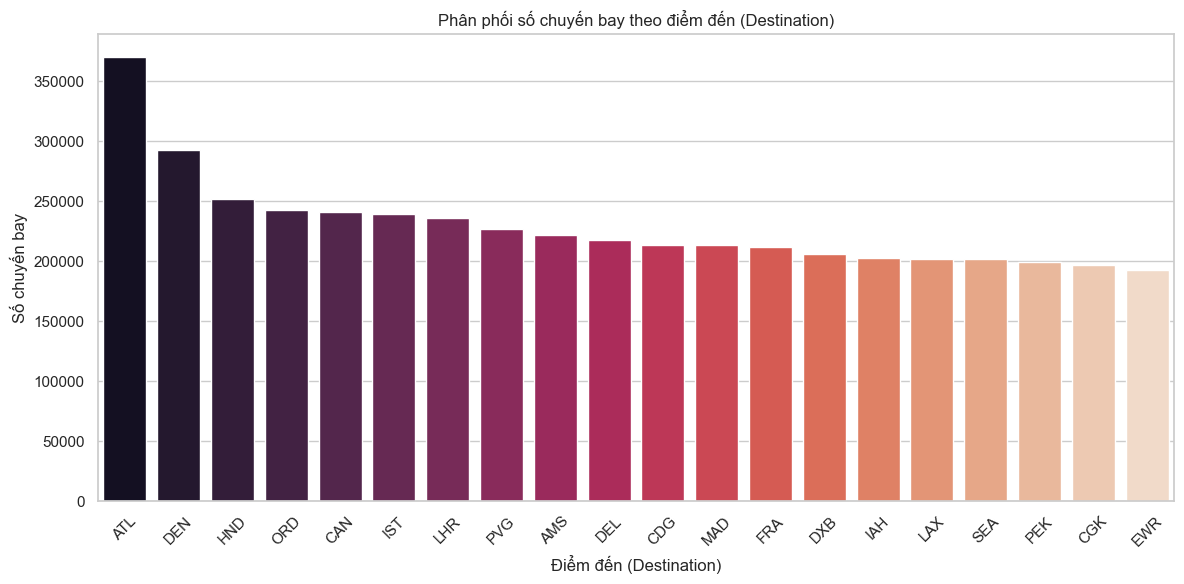

In [5]:
query_destination = """
SELECT 
  destination,
  COUNT(*) AS flight_count
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
GROUP BY destination
ORDER BY flight_count DESC
LIMIT 20
"""

df_destination = client.query(query_destination).to_dataframe()

plt.figure(figsize=(12,6))
sns.barplot(data=df_destination, x='destination', y='flight_count', palette='rocket')
plt.title("Phân phối số chuyến bay theo điểm đến (Destination)")
plt.xlabel("Điểm đến (Destination)")
plt.ylabel("Số chuyến bay")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
query_stats = """
SELECT 'eco' AS cls,
  AVG(economy_emissions_grams_per_pax) AS mean,
  STDDEV(economy_emissions_grams_per_pax) AS std,
  MIN(economy_emissions_grams_per_pax) AS min,
  MAX(economy_emissions_grams_per_pax) AS max
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
UNION ALL
SELECT 'pre', 
  AVG(premium_economy_emissions_grams_per_pax),
  STDDEV(premium_economy_emissions_grams_per_pax),
  MIN(premium_economy_emissions_grams_per_pax),
  MAX(premium_economy_emissions_grams_per_pax)
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
UNION ALL
SELECT 'bus', 
  AVG(business_emissions_grams_per_pax),
  STDDEV(business_emissions_grams_per_pax),
  MIN(business_emissions_grams_per_pax),
  MAX(business_emissions_grams_per_pax)
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
UNION ALL
SELECT 'fir', 
  AVG(first_emissions_grams_per_pax),
  STDDEV(first_emissions_grams_per_pax),
  MIN(first_emissions_grams_per_pax),
  MAX(first_emissions_grams_per_pax)
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`;
"""


df_stats = client.query(query_stats).to_dataframe()

df_stats

,cls,mean,std,min,max
0,bus,274827.910948,1.005522e+06,16333,93017488
1,pre,142899.603370,3.749213e+05,10889,34881558
2,eco,125599.015552,2.498377e+05,10889,23254372
3,fir,309429.131661,1.259747e+06,16333,116271860


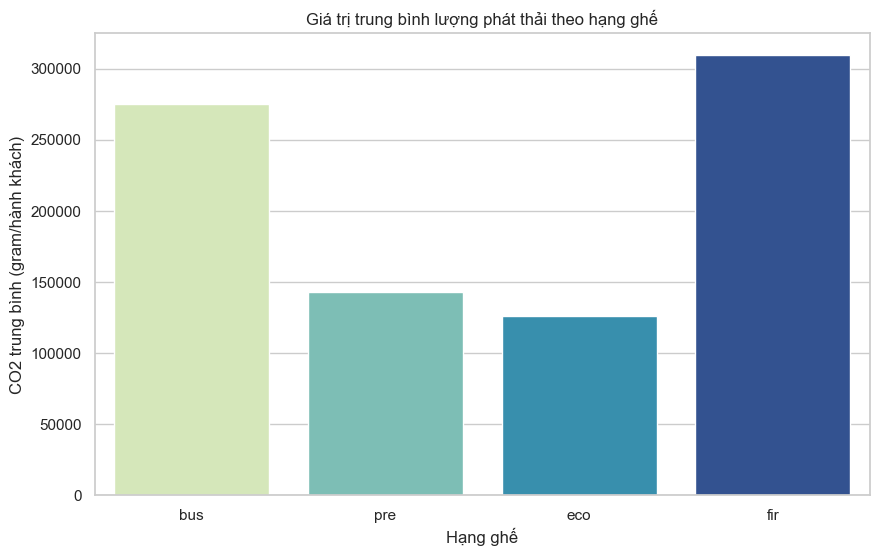

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_stats, x='cls', y='mean', palette='YlGnBu')
plt.title("Giá trị trung bình lượng phát thải theo hạng ghế")
plt.xlabel("Hạng ghế")
plt.ylabel("CO2 trung bình (gram/hành khách)")
plt.show()


In [8]:
query_clean = """
SELECT DISTINCT *
FROM
  `bigquery-public-data.travel_impact_model.flights_impact_data`
WHERE
  economy_emissions_grams_per_pax > 0
LIMIT 1000000;
"""

df = client.query(query_clean).to_dataframe()
df.head()

,carrier,flight_number,departure_date,origin,destination,economy_emissions_grams_per_pax,premium_economy_emissions_grams_per_pax,business_emissions_grams_per_pax,first_emissions_grams_per_pax
0,W1,130,2024-03-21,LBV,POG,27821,27821,41731,41731
1,W1,3086,2024-03-17,SJO,NOB,39132,39132,58698,58698
2,W1,3105,2024-05-20,LIR,SJO,39357,39357,59035,59035
3,W1,1023,2024-03-11,KIS,WIL,44478,44478,66717,66717
4,W1,353,2024-08-13,PFO,TLV,47255,47255,70882,70882


In [9]:
data = df.copy()

In [10]:
data = data.rename(columns={
    "carrier": "airline",
    "flight_number": "flight",
    "departure_date": "date",
    "origin": "from",
    "destination": "to",
    "economy_emissions_grams_per_pax": "eco",
    "premium_economy_emissions_grams_per_pax": "pre",
    "business_emissions_grams_per_pax": "bus",
    "first_emissions_grams_per_pax": "fir"
})

In [11]:
data.describe()

,eco,pre,bus,fir
count,1000000.0,1000000.0,1000000.0,1000000.0
mean,125115.108631,142129.955663,272677.289216,306707.028163
std,240051.224842,360257.195609,966574.022085,1211133.899965
min,15718.0,15718.0,23577.0,23577.0
25%,64080.0,64446.0,96745.0,96762.0
50%,93675.0,95100.0,143296.0,143299.0
75%,135063.0,138171.0,212101.0,212701.0
max,16378701.0,24568051.0,65514804.0,81893505.0


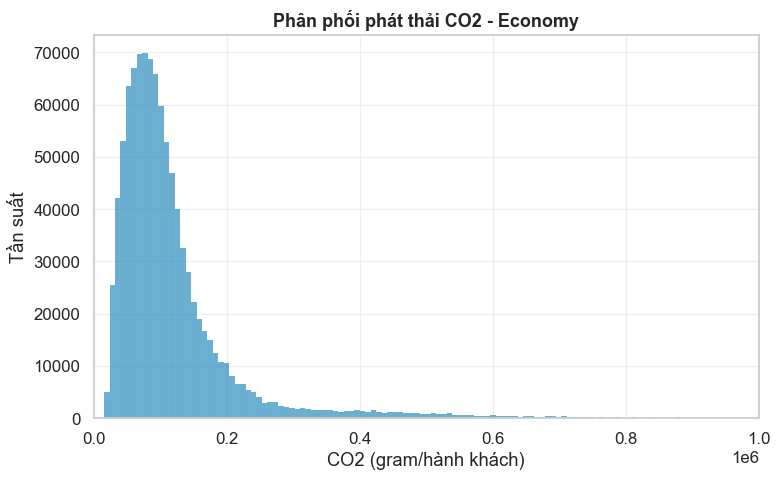

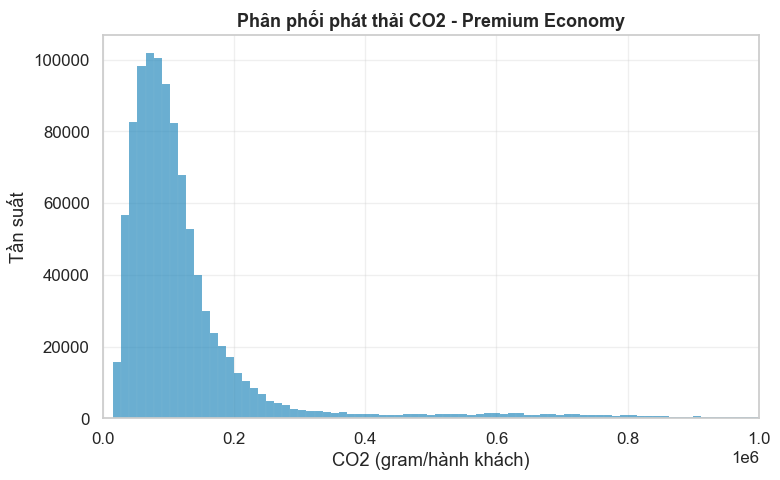

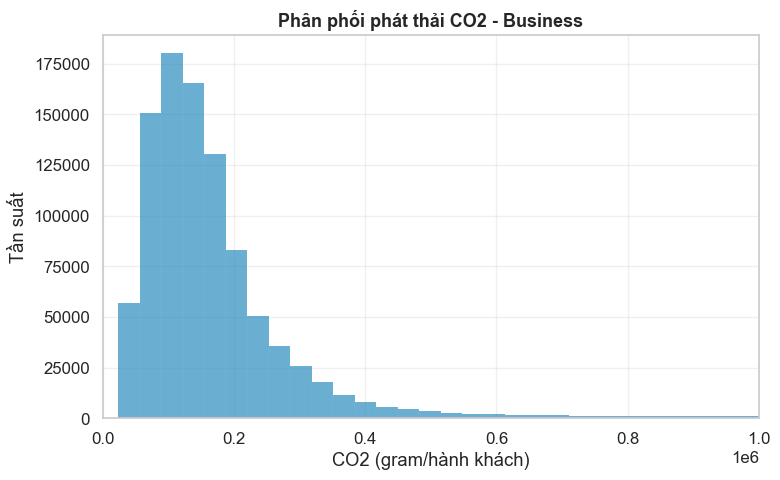

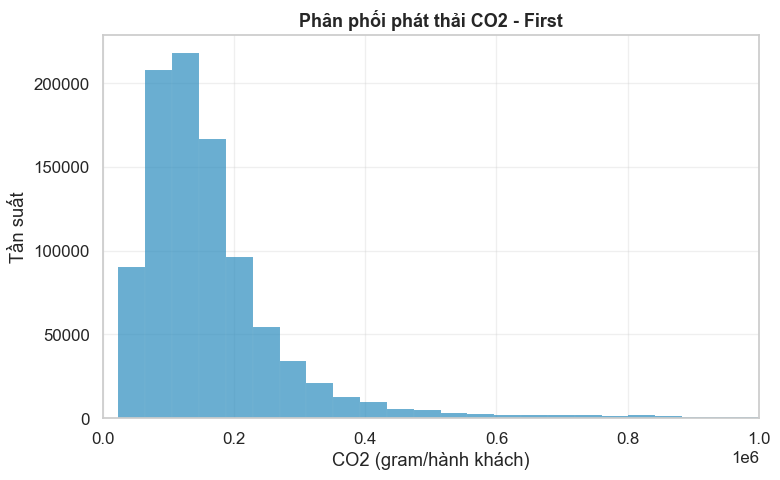

In [19]:
sns.set(style="whitegrid", palette="crest", font_scale=1.1)

classes = {
    "eco": "Economy",
    "pre": "Premium Economy",
    "bus": "Business",
    "fir": "First"
}


for col, label in classes.items():
    plt.figure(figsize=(8,5))
    sns.histplot(data[col], color="#2b8cbe", alpha=0.7)
    plt.title(f"Phân phối phát thải CO2 - {label}", fontsize=13, fontweight="bold")
    plt.xlabel("CO2 (gram/hành khách)")
    plt.ylabel("Tần suất")
    plt.grid(alpha=0.3)
    plt.xlim(0, 0.1*1e7)
    plt.tight_layout()
    plt.show()


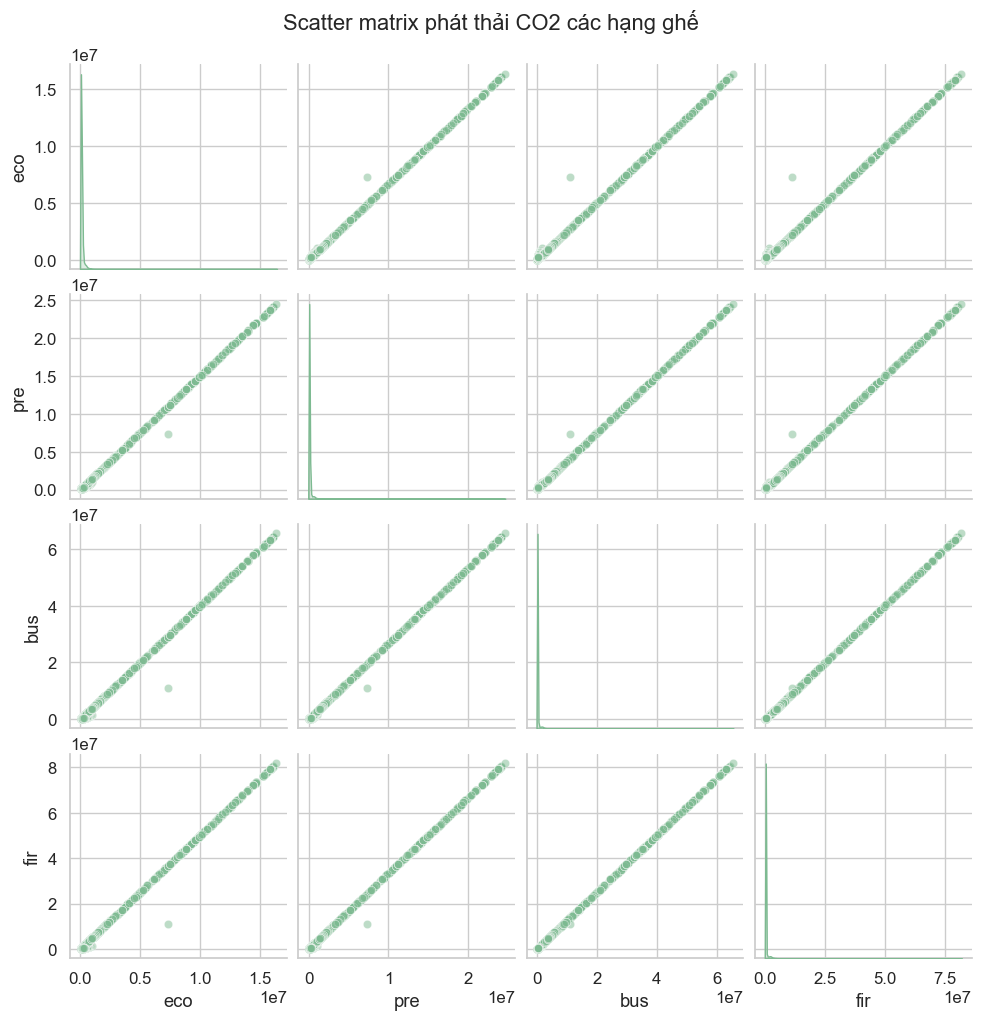

In [21]:
sns.pairplot(data[["eco","pre","bus","fir"]], kind="scatter", diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Scatter matrix phát thải CO2 các hạng ghế", y=1.02)
plt.show()


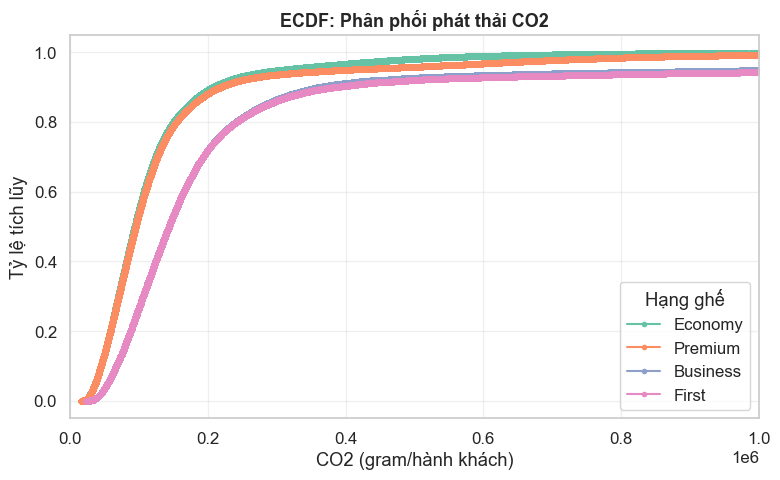

In [26]:
plt.figure(figsize=(8,5))

colors = sns.color_palette("Set2", 4)

classes = ["eco","pre","bus","fir"]
labels = ["Economy","Premium","Business","First"]

for col, label, color in zip(classes, labels, colors):
    x = np.sort(data[col])
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, marker='.', linestyle='-', label=label, color=color)

plt.title("ECDF: Phân phối phát thải CO2", fontsize=13, fontweight='bold')
plt.xlabel("CO2 (gram/hành khách)")
plt.ylabel("Tỷ lệ tích lũy")
plt.xlim(0,0.1* 1e7)
plt.grid(alpha=0.3)
plt.legend(title="Hạng ghế")
plt.tight_layout()
plt.show()


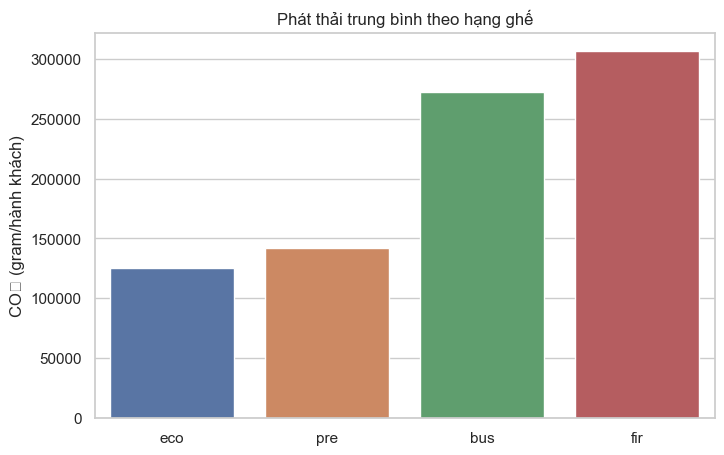

In [21]:
mean_emis = data[["eco", "pre", "bus", "fir"]].mean().reset_index()
mean_emis.columns = ["Class", "Avg"]

plt.figure(figsize=(8,5))
sns.barplot(data=mean_emis, x="Class", y="Avg", hue="Class", dodge=False)
plt.title("Phát thải trung bình theo hạng ghế")
plt.ylabel("CO₂ (gram/hành khách)")
plt.xlabel("")
plt.legend([],[], frameon=False)
plt.show()

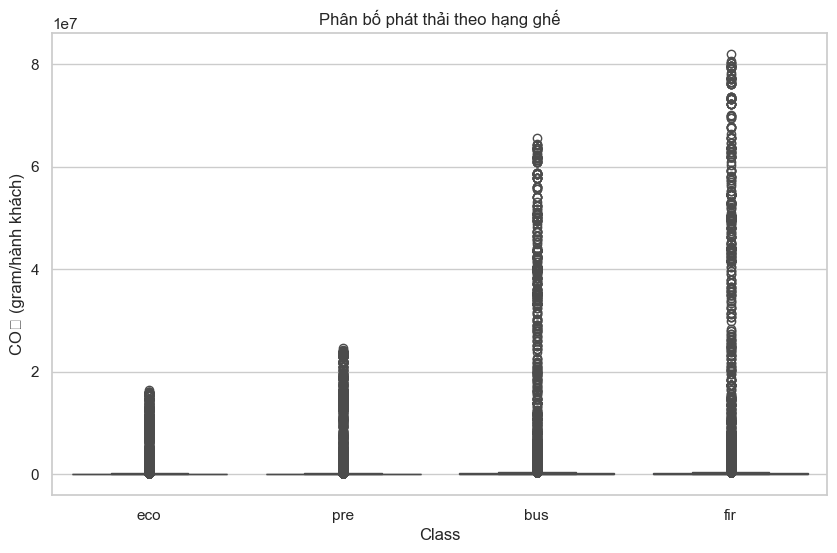

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=pd.melt(data, id_vars=["flight"], value_vars=["eco","pre","bus","fir"],
                 var_name="Class", value_name="Emission"),
    x="Class", y="Emission"
)
plt.title("Phân bố phát thải theo hạng ghế")
plt.ylabel("CO₂ (gram/hành khách)")
plt.show()

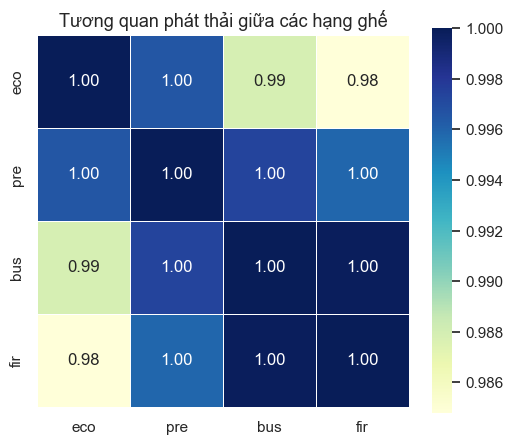

In [25]:
plt.figure(figsize=(6,5))
sns.heatmap(
    data[["eco","pre","bus","fir"]].corr(),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f",
    square=True,
    linewidths=0.6
)
plt.title("Tương quan phát thải giữa các hạng ghế", fontsize=13)
plt.show()


In [28]:
query_trend = """
SELECT
  EXTRACT(YEAR FROM departure_date) AS year,
  EXTRACT(MONTH FROM departure_date) AS month,
  AVG(economy_emissions_grams_per_pax) AS avg_economy
FROM `bigquery-public-data.travel_impact_model.flights_impact_data`
GROUP BY year, month
ORDER BY year, month
"""

trend = client.query(query_trend).to_dataframe()

In [30]:
trend

,year,month,avg_economy
0,2024,3,125958.807670
1,2024,4,122349.137633
2,2024,5,121871.743609
3,2024,6,121723.395387
4,2024,7,122127.126140
5,2024,8,123223.843704
6,2024,9,123135.314269
7,2024,10,124038.891423
8,2024,11,129890.923536
9,2024,12,132596.137102


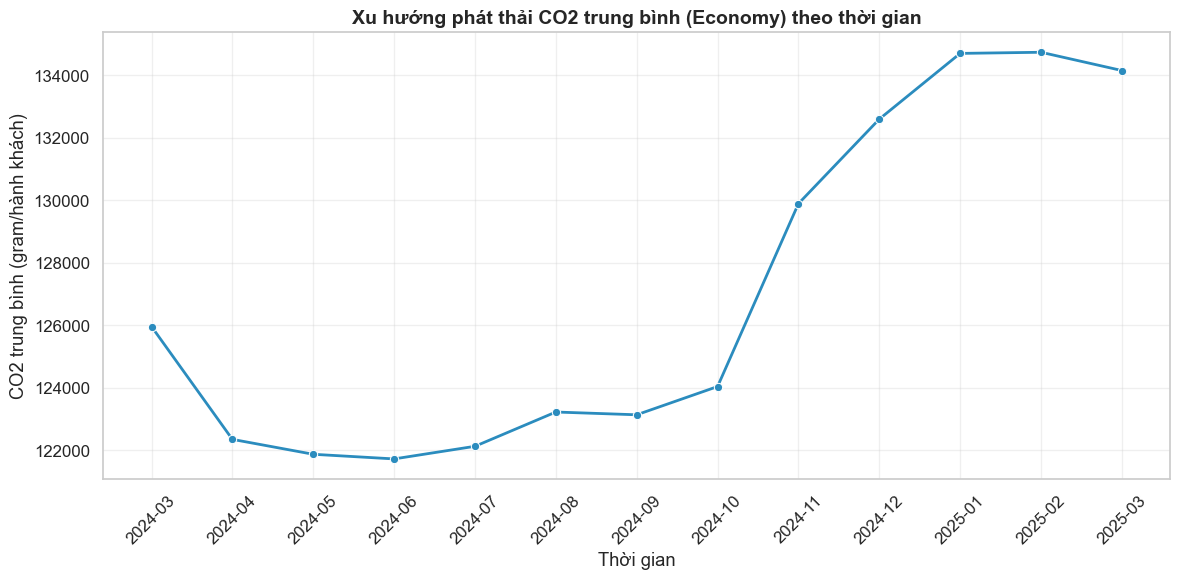

In [33]:
trend['date'] = trend['year'].astype(str) + '-' + trend['month'].astype(str).str.zfill(2)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=trend,
    x='date',
    y='avg_economy',
    marker='o',
    linewidth=2,
    color='#2b8cbe',
    markersize=6
)

plt.title("Xu hướng phát thải CO2 trung bình (Economy) theo thời gian", fontsize=14, fontweight='bold')
plt.xlabel("Thời gian")
plt.ylabel("CO2 trung bình (gram/hành khách)")

plt.xticks(rotation=45)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()